In [182]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
import json
import spacy
from sklearn.cluster import AgglomerativeClustering, KMeans
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [184]:
from utils.character_attributes_extraction import character_names_from_text, character_attributes_from_text, character_active_verbs_from_text, character_patient_verbs_from_text
from utils.clustering import get_lda_clusters, sort_meaningful
from utils.clustering_evaluation import get_characters_with_tv_trop_info, group_labels_by_clusters, variation_of_information, unsupervised_evaluation
from utils.imdb_ratings import movies_with_imdb_rating
from utils.cluster_interpretation import plot_topic_distribution

In [185]:
np.random.seed(2)

# Archetypes Revealing

The basis of our data story is clustering: we grouped movie characters into 50 archetypes using the Latent Dirichlet Allocation method.

For detailed explanations with examples and illustrations please refer
- to `extract_character_attributes.ipynb` or extracting characters and their attributes from the plot texts

- to `clustering.ipynb` for the clustering method: there you can find the methods comparison and the pipeline for characters clustering.

Here we will show only the main logic

## Attribute extraction

For the attribute extraction we will use [Spacy](https://spacy.io/usage/linguistic-features) - library that allows to do many nlp tasks easily.
We will primarily employ named entity recognition and dependency parsing. Additionally, for embeddings, we will utilize the built-in word2vec model.

For every plot we find characters and their dependencies in 3 groups: attributes, active verbs and patient verbs and save it to csv file.
As this procedure takes more than 5h to run, we just refer to `utils.character_attributes_extraction.py` and load attributes extracted by attributes_extraction function.


In [186]:
characters_attributes =  pd.read_csv(
    'data/character_attributes.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )
# keep only characters with >= 3 attributes
characters_attributes = sort_meaningful(characters_attributes, 3)

## Clustering

First, we extract tv tropes as ground truth clustering

In [187]:
characters_to_check, tv_tropes = get_characters_with_tv_trop_info(characters_attributes)

Then we use word2vec embeddings to do Latent Dirichlet Allocation with different numbers of topics and AgglomerativeClustering with different numbers of clusters.

In [188]:
agglomerative_clusters_n = [25, 50, 100]
n_components = [25, 50, 100]

configs = {}
config_base = {'characters': characters_to_check, 'min_freq': 5, 'max_freq':0.9}

for alg_n in agglomerative_clusters_n:
    for n in n_components:
        config = config_base.copy()
        config['clustering_algo'] = AgglomerativeClustering(n_clusters=alg_n, metric='cosine', linkage='complete')
        config['n_components'] = n
        configs[f'{alg_n} topics, {n} archetypes'] = config

results_lda = {}
for k, config in configs.items():
    clusters = get_lda_clusters(**config)
    results_lda[k] = variation_of_information(group_labels_by_clusters(clusters), tv_tropes)
    print(k, f'VI = {results_lda[k]}')

clear_output(wait=True)
results_lda

{'25 topics, 25 archetypes': 6.225834811661815,
 '25 topics, 50 archetypes': 5.707485152623753,
 '25 topics, 100 archetypes': 5.419579188502993,
 '50 topics, 25 archetypes': 6.415766540143924,
 '50 topics, 50 archetypes': 5.716345608383027,
 '50 topics, 100 archetypes': 5.086192744862351,
 '100 topics, 25 archetypes': 6.2519898449870315,
 '100 topics, 50 archetypes': 5.637342058126141,
 '100 topics, 100 archetypes': 4.901819882719251}

Note, that the results are even better (K=100, P=100, 5.42 in the paper and 4.9 here) than the results from the [paper](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf). That could indicate that using word2vec embeddings and Agglomerative clustering of the words to topics might be better suited for dividing the words into topics for the purpose of personas extraction.

We also experimented with clustering based on Bert embeddings: (refer to `utils/archive/transformer_embeddings.ipynb` for the pipeline):
- obtain the character's embedding from the pre-trained BERT model
- perform clustering (Agglomerative or KMeans) using these embeddings.

So the LDA method first extracts linguistic features and then finds word2vec embeddings for them as soon as BERT-based clustering directly obtains the character’s embedding. Thus, LDA is a more explainable method because we know the attributes of every cluster.

As the BERT-based method didn’t significantly outperform the LDA-based one, we chose LDA for our analysis due to its speed advantage and explainability.

Then we experiment with different numbers of clusters (from 10 till 100 with step 5) to find the golden mean.
Evaluation is done by Within-Cluster Sum of Squares (more - better) and Silhouette score (less - better).

In [189]:
# sample 1000 of charactres for faster clustering
characters_for_eval = characters_attributes.sample(1000).reset_index(drop=True)

In [190]:
clustering_algo = AgglomerativeClustering(n_clusters=200, metric='cosine', linkage='complete')

k_values = np.arange(10, 101, 5)
wsss = []
silhouettes = []
min_wss_idx = 0

for i in tqdm(range(len(k_values))):
    y, X = get_lda_clusters(characters_for_eval, 5, 0.9, clustering_algo, k_values[i], return_topic_counts=True)
    wss, silhouette = unsupervised_evaluation(X, y)
    wsss.append(wss)
    silhouettes.append(silhouette)
    clear_output(wait=True)

100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


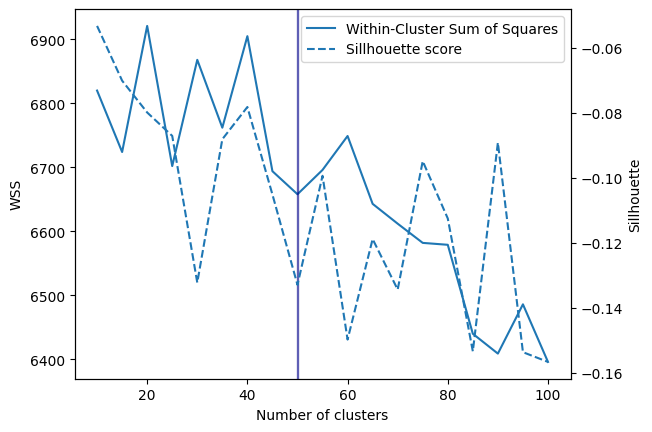

In [191]:
fig, ax1 = plt.subplots()
x = k_values
y1 = wsss
y2 = silhouettes

ax1.plot(x, y1, label='Within-Cluster Sum of Squares')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WSS')

ax2 = ax1.twinx()
ax2.plot(x, y2, label='Sillhouette score', linestyle='dashed')
ax2.set_ylabel('Sillhouette')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
plt.axvspan(50, 50.1, alpha=0.5,  color='darkblue')


We can see, that the 50 clusters provide relatively good combination of the silhouette and WSS scores and is still manageable to interpret. 

So we fix clustering, save the results and LDA topics.

In [192]:
clustering_algo = AgglomerativeClustering(n_clusters=200, metric='cosine', linkage='complete')

optimal_k = 50

In [193]:
%%script false --no-raise-error
# We want to save components of lda and word clusters (topic_dict) as well as clustering

vocab, vocab_vectors = get_vocab(characters, 5, 0.9)
topic_dict = word_topics_clustering(vocab, vocab_vectors, clustering_algo)
counts = topic_count(characters, topic_dict)
lda = LatentDirichletAllocation(
        n_components=optimal_k, random_state=0
).fit(counts)

characters['cluster'] = lda.transform(counts).argmax(axis=1)
characters.to_csv('data/character_clusters.csv')

In [194]:
%%script false --no-raise-error
topic_to_words = {}

for k, v in topic_dict.items():
    v = str(v)
    if v in topic_to_words:
        topic_to_words[v].append(k)
    else:
        topic_to_words[v] = [k]
        
json.dump( topic_to_words, open( "data/words_by_topic.json", 'w' ) )

In [195]:
%%script false --no-raise-error

with open('data/lda_components.npy', 'wb') as f:
    np.save(f, lda.components_)

# Load the data

Now you understand how we implemented clustering so let's proceed to insights we got from these archetypes.

We start with data loading:
- Characters dataset was obtained by clustering
- Movies, actors, plots were provided to us
- Consumer Price Index (CPI) is taken from [U.S. Bureau of Labor Statistics CPI](https://www.bls.gov/cpi/data.htm) 
- Movie ratings dataset is taken from [IMDB Movies](https://developer.imdb.com/non-commercial-datasets/)

In [196]:
characters =  pd.read_csv(
    'data/character_clusters.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )

movies = pd.read_csv(
    'data/MovieSummaries/movie.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'title', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']
)

actors = pd.read_csv(
    'data/MovieSummaries/character.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'release_date', 'character', 'date_of_birth', 'sex', 'height', '.','actor','age','character_map','..','...','....']
)

In [197]:
# load inflation data
cpi_data = pd.read_csv('data/cpi_data.csv', )
cpi_data.head()

,year,cpi
0,1913,9.9
1,1914,10.0
2,1915,10.1
3,1916,10.9
4,1917,12.8


In [198]:
# create dataframe combining actors data, character's name, movie id and clustering results (attributes and resulted cluster)
def same_name(names1, names2):
    names1 = names1.values
    names2 = names2.values
    flag = []
    for i in range(len(names1)):
        flag.append(names1[i] in names2[i])
    return flag


actors_and_characters = characters.merge(actors, how='left', left_on='wiki_id', right_on='wiki_id').dropna(subset=['character_y'])

actors_and_characters = actors_and_characters[same_name(actors_and_characters['character_x'], actors_and_characters['character_y'])]
actors_and_characters['character'] = actors_and_characters['character_x']
actors_and_characters = actors_and_characters.drop(columns=['character_x', 'character_y'])
actors_and_characters = actors_and_characters[['character', 'actor', 'cluster', 'wiki_id', 'release_date', 'date_of_birth', 'sex', 'height', 'age', 'adj', 'active', 'patient']]
actors_and_characters.sample(5)

,character,actor,cluster,wiki_id,release_date,date_of_birth,sex,height,age,adj,active,patient
644740,Bernice,Sarah Steele,49,1274324,2004-12-17,1988-09-16,F,1.524,16.0,"[kid, sensitive]",[],[do]
690473,Jack Bennett,Danny Huston,15,18949667,2010-01-28,1962-05-14,M,1.880,47.0,"[head, gag]","[order, shoot, run]","[tackle, shoot]"
34910,Rafael,Pedro Van-Held,10,28385798,2010-10-08,NaN,M,NaN,NaN,[son],"[grow, arrive]","[shoot, rush]"
187464,Libbey,Don Johnson,1,17705805,1995-03-18,1949-12-15,M,1.800,45.0,"[Sergeant, John, Top]",[refuse],[meet]
471282,David Ackerman,Charlie Sheen,28,1748549,1990-12-07,1965-09-03,M,1.750,25.0,"[partner, officer, Lieutenant]","[learn, track, decide, visit, realize, evade, ...","[shoot, elude, introduce]"


In [199]:
# add revenue discount and format movie dataframe

def discount_revenue(year, revenue):
    if year in cpi_data['year'].values:
        cpi = cpi_data[cpi_data['year'] == year]['cpi'].values[0]
    else:
        cpi = 100
    return (revenue /  cpi)*100


map_dict_to_list = lambda x: [value for key, value in eval(x).items()]
release_year = lambda x: pd.to_numeric(x.str.replace(r'-\d{2}-\d{2}$', '', regex=True).str.replace(r'-\d{2}$', '', regex=True))

movies['languages'] = movies['languages'].apply(map_dict_to_list)
movies['countries'] = movies['countries'].apply(map_dict_to_list)
movies['genres'] = movies['genres'].apply(map_dict_to_list)

movies["release_year"] = release_year(movies['release_date'])
movies["release_year"] = movies['release_year'].apply(lambda x: x if x > 1800 else x + 1000)

movies['discounted_revenue'] = movies.apply(lambda x: discount_revenue(x.release_year, x.revenue), axis=1)

movies.head()

,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,release_year,discounted_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,7.911255e+06
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000.0,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],1983.0,NaN


In [200]:
%%script false --no-raise-error
# We use saved version of IMDB dataset
movies_with_rating = movies_with_imdb_rating(movies)

In [201]:
movies_with_rating = pd.read_csv(
    'data/movies_with_rating.csv', 
    index_col=0,
    converters={
        "languages": map_dict_to_list,
        "countries": map_dict_to_list,
        "genres": map_dict_to_list
        }
    )
    
movies_with_rating['release_year'] = release_year(movies_with_rating['release_date'])
movies_with_rating['discounted_revenue'] = movies_with_rating.apply(lambda x: discount_revenue(x.release_year, x.revenue), axis=1)

movies_with_rating.head()

,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,averageRating,numVotes,release_year,discounted_revenue
0,10109752,/m/02q23xk,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]",5.3,208,1894,NaN
1,28703057,/m/0czdh_n,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,NaN,[],[],[Sports],5.3,485,1897,100000.0
2,142995,/m/0120y4,The Story of the Kelly Gang,1906-12-26,NaN,70.0,[English Language],[Australia],"[Crime Fiction, Silent film, Biography, Indie,...",6.0,855,1906,NaN
3,32986669,/m/04p7yxx,Robbery Under Arms,1907-11-02,NaN,NaN,[Silent film],[Australia],"[Silent film, Drama]",4.3,25,1907,NaN
4,15128675,/m/03hjcy9,Hamlet,1908,NaN,NaN,[French Language],[France],"[Silent film, Drama]",2.9,27,1908,NaN


In [202]:
plots = pd.read_csv(
    'data/MovieSummaries/plot_summaries.txt', 
    sep='\t', 
    names=['wiki_id', 'plot']
)
movies_and_plots = movies.merge(plots, how='right', left_on='wiki_id', right_on='wiki_id')
num_plot = len(pd.unique(movies_and_plots['wiki_id']))

In [203]:
characters_and_movies = characters.merge(movies, left_on='wiki_id', right_on='wiki_id')
num_char = len(pd.unique(characters_and_movies['wiki_id']))

### First look at the data

In [204]:
print(f"Number of movies: {len(movies)}")
print(f"Number of movies with revenue: {movies['revenue'].notna().sum()}")
print(f"Number of movies with rating: {len(movies_with_rating)}")
print(f"Number of movies with rating and revenue: {movies_with_rating['revenue'].notna().sum()}")
print(f"Number of movies with plot: {num_plot}")
print(f"Number of movies, where we find archetypes: {num_char}")
print(f"Number of actors with the characters who have an archetype: {len(actors_and_characters)}")

Number of movies: 81741
Number of movies with revenue: 8401
Number of movies with rating: 39886
Number of movies with rating and revenue: 7339
Number of movies with plot: 42303
Number of movies, where we find archetypes: 25604
Number of actors with the characters who have an archetype: 29724


In [205]:
import plotly.graph_objects as go

# Obtain the data
categories_movie_plot = ["Total Movies", "Movies with Plot", "Movies with Archetypes"]

movie_values = [len(movies),
          num_plot,
          num_char]

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=categories_movie_plot, y=movie_values)])

# Update layout for better visualization
fig.update_layout(
    title="Statistics of Movies with Plots and Archetypes",
    xaxis_title="Categories",
    yaxis_title="Number of Movies",
)

# Show the plot
fig.show()

We observe that nearly half of the movies have plot data, and archetypes have been extracted from only one-third of them.

To explain these results, let's take a look at plots length.

In [206]:
def count_words(sentence):
    words = sentence.split()
    return len(words)

In [207]:
id_with_characters = characters_and_movies['wiki_id'].values
movies_with_arch = movies_and_plots.loc[movies_and_plots['wiki_id'].isin(id_with_characters)]
plot_length_with_arch = movies_with_arch['plot'].apply(count_words) 
plot_length = movies_and_plots['plot'].apply(count_words) 


In [208]:
# create 50 log-scale bins
_, bins_plot = np.histogram(plot_length, bins=50)
_, bins_arch = np.histogram(plot_length_with_arch, bins=50)
logbins_plot = np.logspace(np.log10(bins_plot[0]),np.log10(bins_plot[-1]),len(bins_plot))
logbins_arch = np.logspace(np.log10(bins_arch[0]),np.log10(bins_arch[-1]),len(bins_arch))


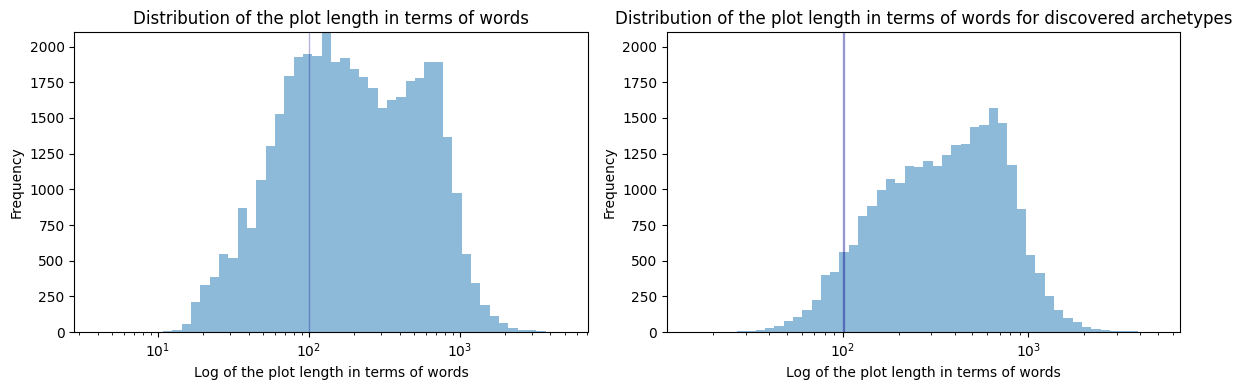

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Subplot 1
axes[0].hist(plot_length, bins=logbins_plot, alpha=0.5)
axes[0].set_xscale('log')
axes[0].set_xlabel('Log of the plot length in terms of words')
axes[0].set_ylabel('Frequency')
axes[0].set_ylim(0,2100)
axes[0].set_title("Distribution of the plot length in terms of words")
axes[0].axvspan(100, 101, alpha=0.3, label='100 words', color='darkblue')

# Subplot 2
axes[1].hist(plot_length_with_arch, bins=logbins_arch, alpha=0.5)
axes[1].set_xscale('log')
axes[1].set_xlabel('Log of the plot length in terms of words')
axes[1].set_ylabel('Frequency')
axes[1].set_ylim(0,2100)
axes[1].set_title("Distribution of the plot length in terms of words for discovered archetypes")
axes[1].axvspan(100, 101, alpha=0.3, label='100 words', color='darkblue')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

And we see clear pattern: in the movies with short plot we obtain archetypes with the lower probability.

If we talk about actors, only small fraction of them played a character with defined archetype.

In [210]:
print(f"Number of actors: {len(actors)}")
print(f"Number of actors with the characters who have an archetype: {len(actors_and_characters)}")
print(f"Number of actors with the characters who have an archetype in the movies with revenue and rating: {len(actors_and_characters[actors_and_characters['wiki_id'].isin(movies_with_rating[movies_with_rating['revenue'].notna()]['wiki_id'])])}")

Number of actors: 450669
Number of actors with the characters who have an archetype: 29724
Number of actors with the characters who have an archetype in the movies with revenue and rating: 13839


### What are the countries of production

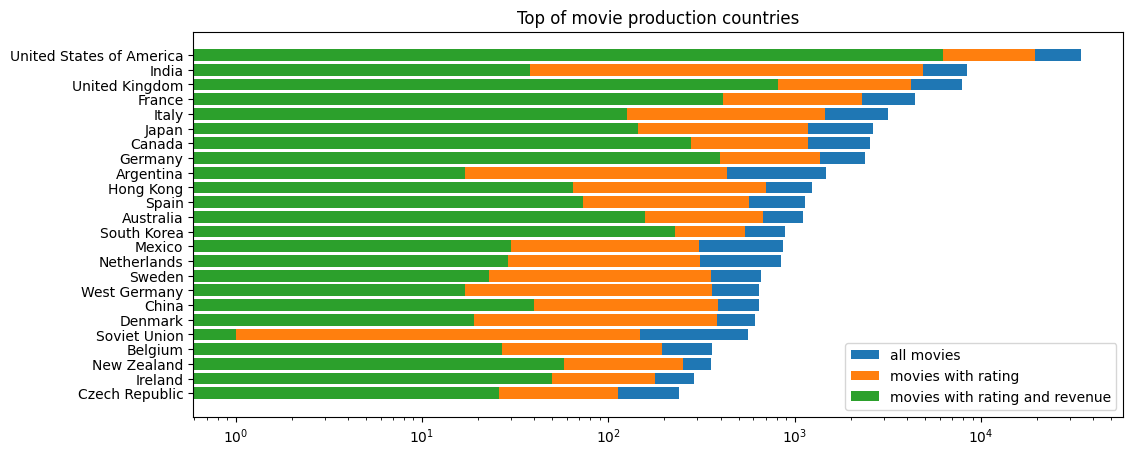

In [211]:
coutries_distr = movies.explode('countries').groupby('countries').size()
coutries_distr_with_rating = movies_with_rating.explode('countries').groupby('countries').size()
coutries_distr_with_rating_and_revenue = movies_with_rating[movies_with_rating['revenue'].notna()].explode('countries').groupby('countries').size()

coutries = list(set(
    coutries_distr.sort_values(ascending=False)[:20].index.to_list() 
    + coutries_distr_with_rating.sort_values(ascending=False)[:20].index.to_list() 
    + coutries_distr_with_rating_and_revenue.sort_values(ascending=False)[:20].index.to_list()))

coutries_distr = coutries_distr.loc[coutries].sort_values(ascending=True)
coutries = coutries_distr.index.to_list() 
coutries_distr_with_rating = coutries_distr_with_rating.loc[coutries]
coutries_distr_with_rating_and_revenue = coutries_distr_with_rating_and_revenue.loc[coutries]

plt.figure(figsize=(12, 5))
plt.title('Top of movie production countries')

plt.barh(coutries_distr.index, coutries_distr.values, label='all movies')
plt.barh(coutries_distr_with_rating.index, coutries_distr_with_rating.values, label='movies with rating')
plt.barh(coutries_distr_with_rating_and_revenue.index, coutries_distr_with_rating_and_revenue.values, label='movies with rating and revenue')

plt.xscale('log')
plt.legend()

plt.show()

We can notice that most of the movies in the dataset are made in the US, moreover, we have much less data for movies with revenue and this data is't distributed prportionally to the overall number of movies produced in the country.

### What is the historical distribution

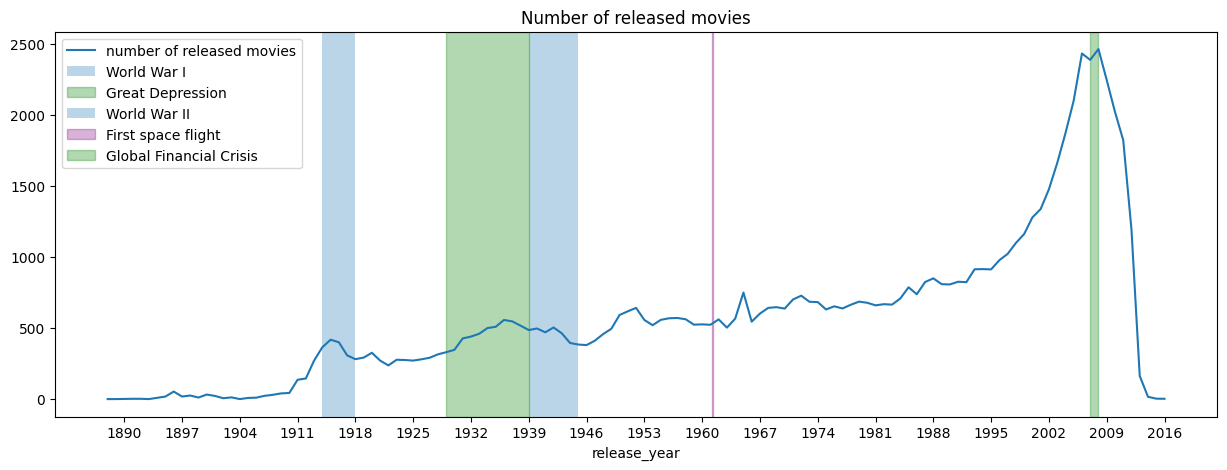

In [212]:
movies.groupby('release_year').size().plot(figsize=(15, 5), title='Number of released movies', label='number of released movies')
plt.xticks(np.arange(1890, 2021, 7))

plt.axvspan(1914, 1918, alpha=0.3, label='World War I')
plt.axvspan(1929, 1939, alpha=0.3, label='Great Depression', color='green')
plt.axvspan(1939, 1945, alpha=0.3, label='World War II')
plt.axvspan(1961.2, 1961.3, alpha=0.3, label='First space flight', color='purple')
plt.axvspan(2007, 2008, alpha=0.3, label='Global Financial Crisis', color='green')

plt.legend()

plt.show()

We don't have much data before 1910-s and after 2012.

# Clusters interpretation
To interpret clusters, we can use the function `plot_topic_distribution` to see the topics with the largest probabilities to be in the cluster.

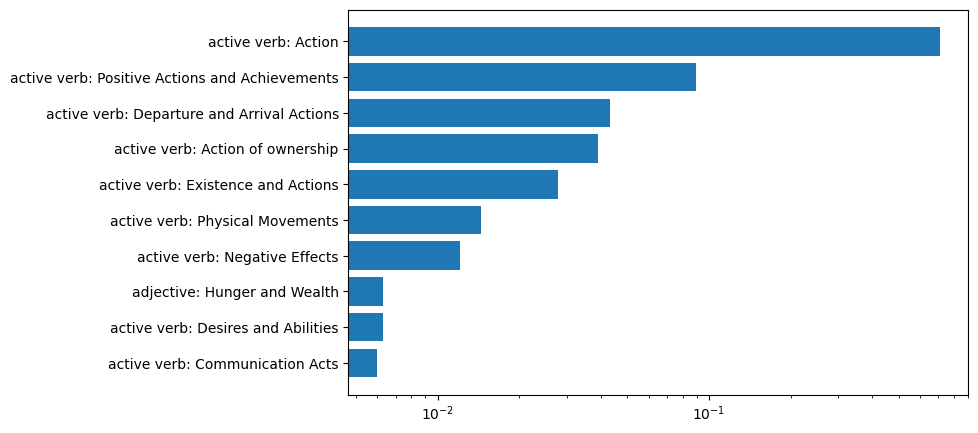

In [213]:
plot_topic_distribution(42)

# Historycal trends

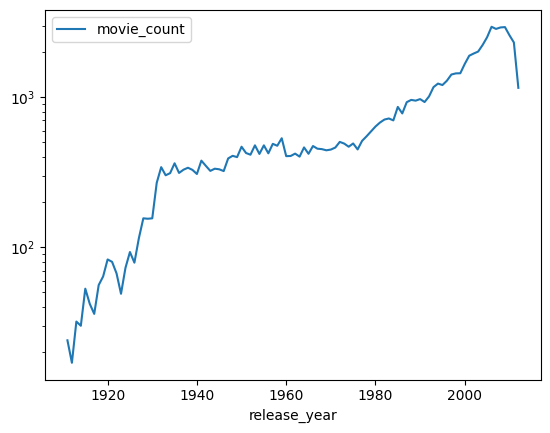

In [214]:
movies_count = characters_and_movies.groupby('release_year').size().reset_index(name='movie_count')
movies_count = movies_count[movies_count['movie_count'] >= 15]
movies_count.plot(x='release_year', y='movie_count')
plt.yscale('log')

Comment: We decide to analyze trends where there is a stable abundance of data, and remove movies before 1932 and tha last two years (2013-2014). For further analysis we are selecting important clusters (by relative popularity or changes in popularity) but this selection is skewed by the years where there is little data since that gives a very high proportion for every cluster. So the early clusters will appear very significant despite that not being the case (if e.g. there are only a handful of movies, the archetype distribution is not very interesting). Therefore the filtered subset is used, not only for plot, but also for cluster ranking.

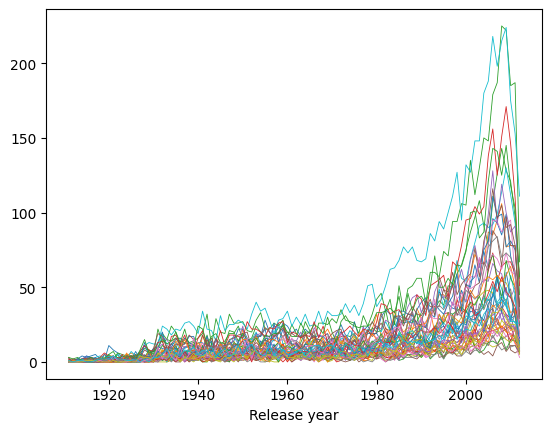

In [215]:
archetype_counts = characters_and_movies[characters_and_movies['release_year'].isin(movies_count['release_year'])].groupby(['release_year', 'cluster']).size().reset_index(name='character_count')
archetype_counts = archetype_counts.pivot(index='release_year', columns='cluster', values='character_count').fillna(0)
archetype_counts.plot(legend=False, linewidth = .6)
plt.xlabel("Release year")
plt.show()

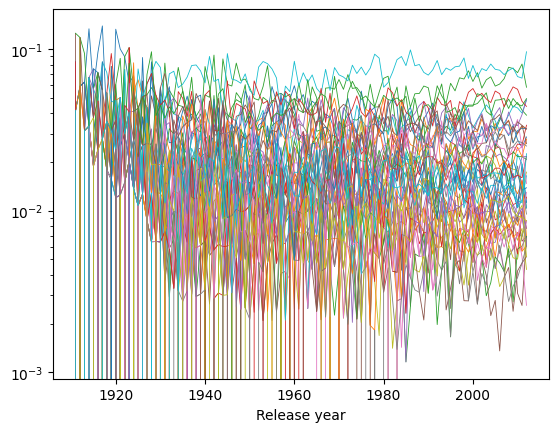

In [216]:
normalized_archetype_counts = (archetype_counts)/(archetype_counts.values.sum(1).reshape(-1, 1))
normalized_archetype_counts.plot(legend=False, linewidth = .6)
plt.yscale('log')
plt.xlabel("Release year")
plt.show()

It is hard to see any patterns here, so we will analyze top archetypes only.

### Top archetypes

- By the highest sum of normalized frequency (popularity)
- By the biggest range in normalized frequency (changes in popularity)

In [217]:
normalized_archetype_counts = normalized_archetype_counts.loc[(normalized_archetype_counts.index <= 2012) & (normalized_archetype_counts.index >= 1932)]

In [218]:
# sum of normalized frequency

top_clusters = normalized_archetype_counts.sum(0).sort_values(ascending=False)[:5].index.values
top_clusters_archetype_counts = normalized_archetype_counts[top_clusters]

# biggest range in normalized frequency

top_diff_clusters = normalized_archetype_counts.apply(np.ptp).sort_values(ascending=False)[:5].index.values
top_clusters_archetype_diff = normalized_archetype_counts[top_diff_clusters]
top_clusters_archetype_diff

print("top_clusters_archetype_counts:", list(top_clusters_archetype_counts.columns), "\n" +
      "top_clusters_archetype_diff:", list(top_clusters_archetype_diff.columns))

top_clusters_archetype_counts: [19, 12, 42, 33, 2] 
top_clusters_archetype_diff: [12, 19, 42, 2, 33]


The top clusters for both selections are the same (but in a different order), which is convenient for further analysis. 

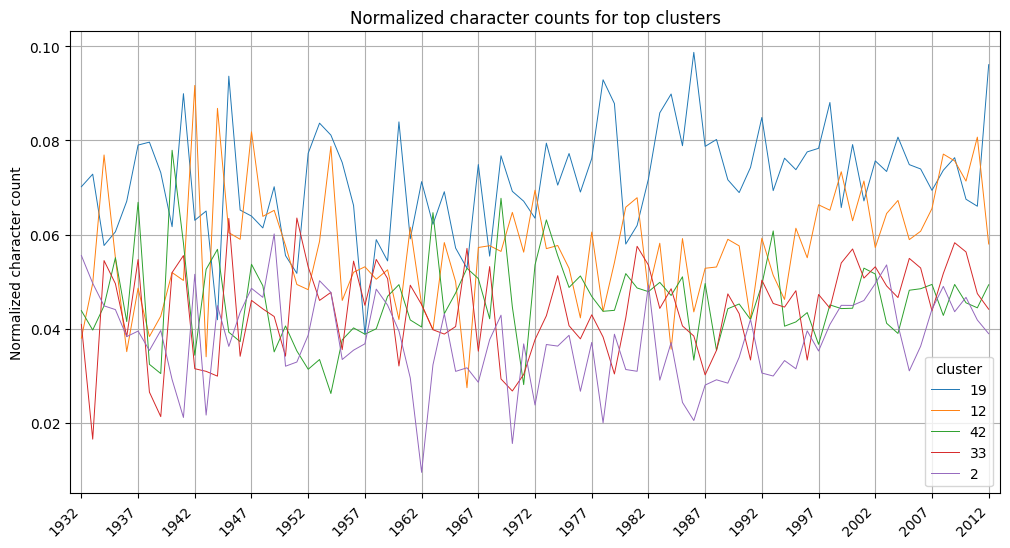

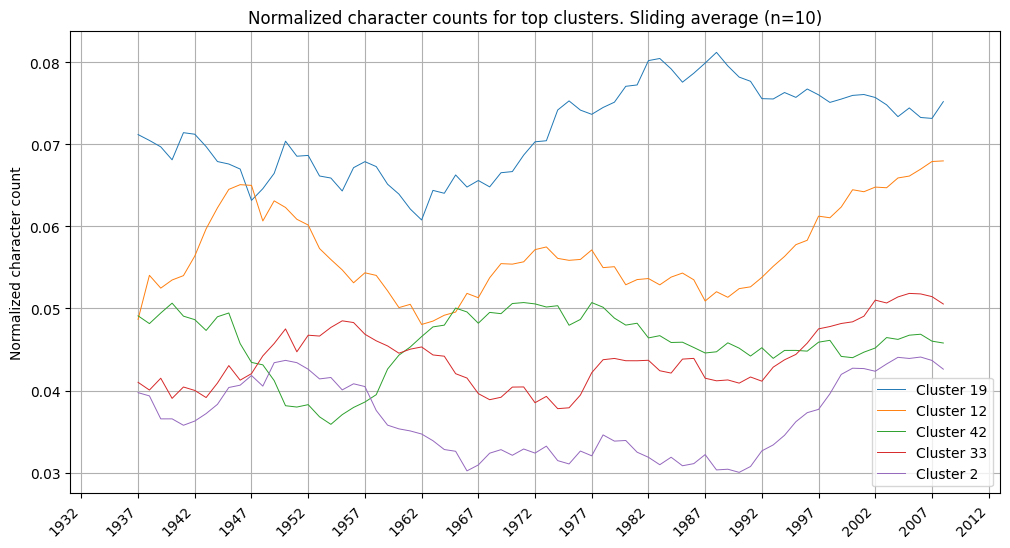

In [219]:
top_clusters_archetype_counts.plot(figsize=(12, 6), linewidth = .7)
#plt.yscale("log")
plt.xticks(top_clusters_archetype_counts.index[::5], rotation=45, ha='right')
plt.xlim([1931, 2013])
plt.xlabel('')
plt.ylabel('Normalized character count')
plt.title('Normalized character counts for top clusters')
plt.grid(True)
plt.show()

# -----------------------------------
n = 10 # sliding average window size

plt.figure(figsize=(12, 6))

# Iterate over clusters and plot a line for each
for cluster in top_clusters:
    x = top_clusters_archetype_counts[cluster]
    x_avg = np.convolve(x, np.ones(n)/n, mode='valid')
    y = top_clusters_archetype_counts.index
    y_1 = y[round(n/2):-(n-round(n/2))+1]
    plt.plot(y_1, x_avg, label=f'Cluster {cluster}', marker='', linewidth=0.7)

#plt.yscale("log")
plt.xticks(top_clusters_archetype_counts.index[::5], rotation=45, ha='right')
plt.xlim([1931, 2013])
plt.xlabel('')
plt.ylabel('Normalized character count')
plt.title(f'Normalized character counts for top clusters. Sliding average (n={n})')
plt.legend()
plt.grid(True)
plt.show()

#### Interpretation

In [220]:
def print_cluster_info(n):
    print('Cluster: ', n)
    top = characters_and_movies[(characters_and_movies['cluster'] == n) & (characters_and_movies['revenue'] > 5e8)]
    top = top.sort_values(by='revenue', ascending=False).head(5)
    print(top[['title', 'character']])
    plot_topic_distribution(n)

Cluster:  19
                                               title            character
50598                                        Titanic          Jack Dawson
50600                                        Titanic  Rose DeWitt Bukater
73920  Harry Potter and the Deathly Hallows – Part 2                 Wand
74358    Pirates of the Caribbean: On Stranger Tides         Jack Sparrow
35637       Harry Potter and the Philosopher's Stone         Harry Potter


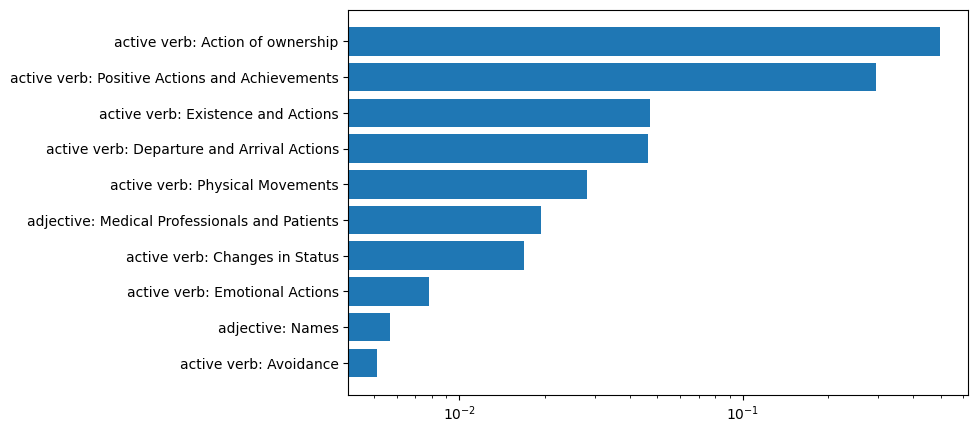

Cluster:  12
                                               title      character
54389                                         Avatar           Jake
66442                                   The Avengers           Thor
73918  Harry Potter and the Deathly Hallows – Part 2  Severus Snape
73990  The Lord of the Rings: The Return of the King         Pippin
73988  The Lord of the Rings: The Return of the King          Frodo


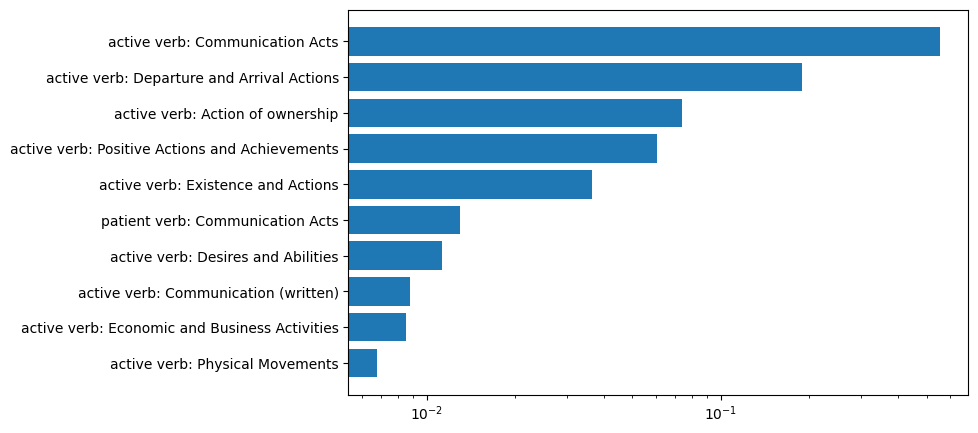

Cluster:  42
                                title         character
66440                    The Avengers  Natasha Romanoff
66446                    The Avengers      Bruce Banner
66445                    The Avengers         Nick Fury
66444                    The Avengers        Tony Stark
9195   Transformers: Dark of the Moon           Optimus


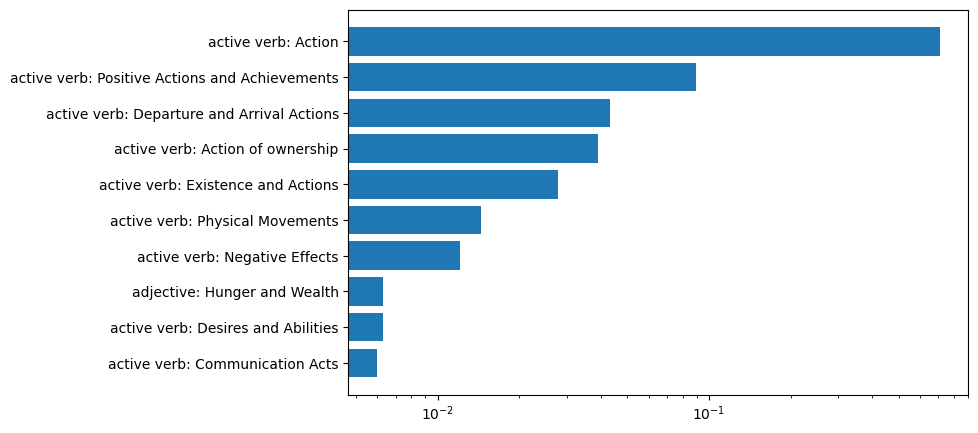

Cluster:  33
                            title     character
66441                The Avengers  Steve Rogers
19174       The Dark Knight Rises        Batman
15123             Shrek the Third          Puss
5358   E.T. the Extra-Terrestrial        Gertie
14969                Transformers     Bumblebee


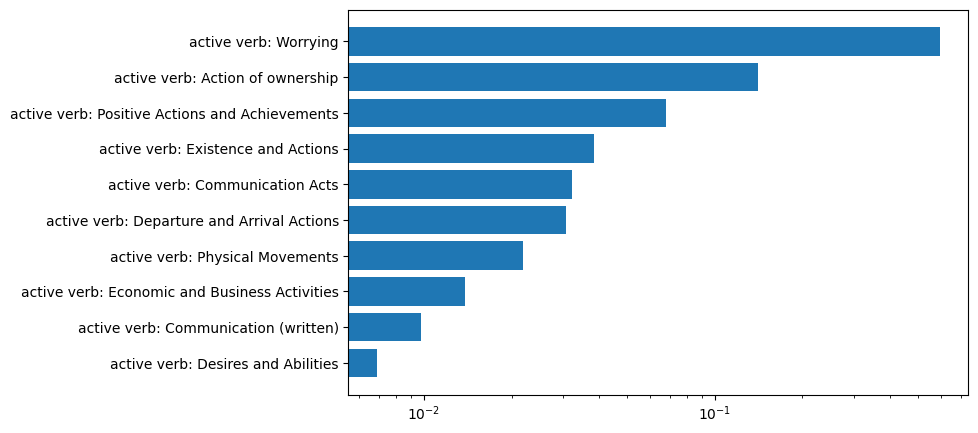

Cluster:  2
                                          title         character
50599                                   Titanic               Cal
35643  Harry Potter and the Philosopher's Stone  Albus Dumbledore
20361  Pirates of the Caribbean: At World's End         Elizabeth
38862                              Spider-Man 3       Flint Marko
38863                              Spider-Man 3      Peter Parker


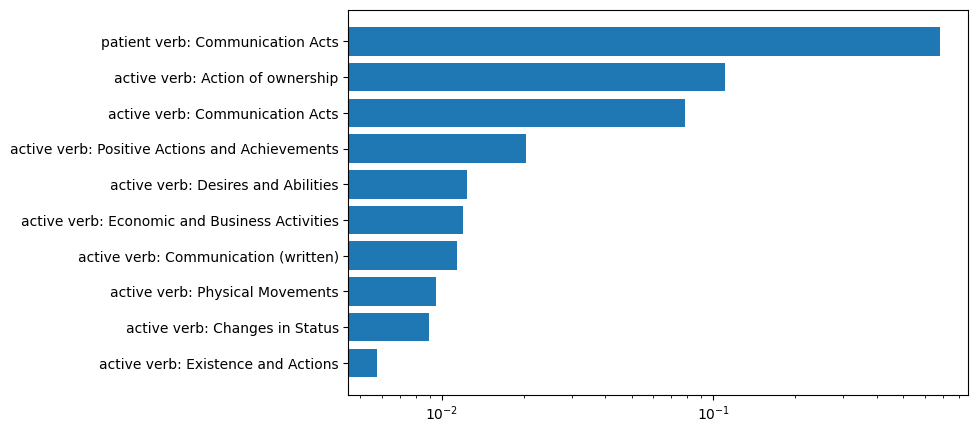

In [221]:
for cluster in top_clusters[:5]:
    print_cluster_info(cluster)

We can notice that the three most popular archetypes are all archetypes of different kinds of protagonists and their close allies, and the archetypes that changed in popularity are mostly side caracters.

# Cultural preference

We are interested in the cultural preferences at more modern times, so we will look only at the data from the 21 century. We also will use only the first country in the list of production countries.

In [222]:
char_movies_countries = characters_and_movies[characters_and_movies['release_year'] > 2000]
char_movies_countries['countries'] = char_movies_countries['countries'].apply(lambda x: x[0] if x else 'Unknown')

char_movies_countries = char_movies_countries.groupby(['countries', 'cluster']).size().reset_index(name='character_count')

char_movies_countries = char_movies_countries[['countries', 'cluster', 'character_count']]

/tmp/ipykernel_10365/2187779735.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [223]:
# top production countries
char_movies_countries.groupby('countries')['character_count'].sum().sort_values(ascending=False)[:50].index

Index(['United States of America', 'India', 'Unknown', 'France', 'Japan',
       'United Kingdom', 'Canada', 'South Korea', 'Hong Kong', 'Australia',
       'Spain', 'Philippines', 'Thailand', 'Germany', 'Ireland', 'Italy',
       'China', 'Mexico', 'Russia', 'Denmark', 'Indonesia', 'Singapore',
       'Netherlands', 'South Africa', 'Malaysia', 'Austria', 'Sweden',
       'Belgium', 'Brazil', 'Argentina', 'Turkey', 'Poland', 'New Zealand',
       'Pakistan', 'England', 'Switzerland', 'Finland', 'Norway', 'Colombia',
       'Romania', 'Israel', 'Bangladesh', 'Iran', 'Cambodia', 'Serbia',
       'Iceland', 'Bulgaria', 'Burma', 'Taiwan', 'Nepal'],
      dtype='object', name='countries')

In [224]:
archetype_by_country = char_movies_countries.pivot(index='countries', columns='cluster', values='character_count').fillna(0)
archetype_by_country

cluster,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
countries,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Argentina,1.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0
Australia,5.0,8.0,15.0,4.0,4.0,3.0,1.0,3.0,1.0,11.0,...,6.0,3.0,22.0,8.0,8.0,8.0,7.0,15.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United States of America,262.0,447.0,718.0,173.0,126.0,84.0,87.0,200.0,116.0,628.0,...,284.0,335.0,757.0,277.0,126.0,451.0,395.0,384.0,166.0,178.0
Unknown,14.0,53.0,61.0,15.0,13.0,11.0,7.0,16.0,7.0,56.0,...,20.0,25.0,72.0,21.0,19.0,46.0,36.0,26.0,22.0,28.0
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [225]:
def load_dict_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    return dict(zip(df['Country'], df['Continent']))

In [226]:
country_to_continent = load_dict_from_csv('data/country_continent.csv')

There are quite a lot of films with unknown country of production so we'll drop them.

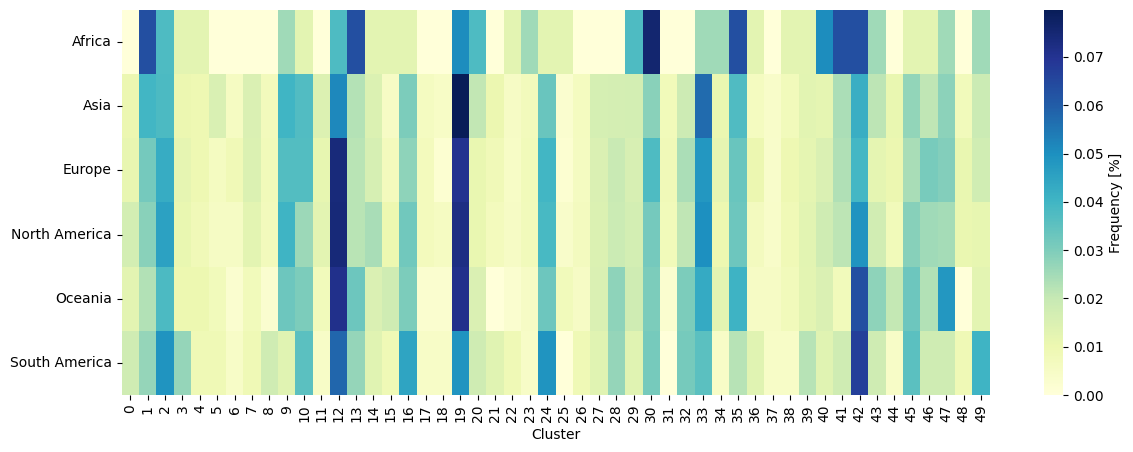

In [227]:
archetype_by_continent = archetype_by_country.copy()

# Group by continent and sum the values for each cluster
archetype_by_continent['continent'] = archetype_by_continent.index.map(country_to_continent)
archetype_by_continent = archetype_by_continent[archetype_by_continent['continent'] != 'Unknown']
archetype_by_continent = archetype_by_continent.groupby('continent').sum()

# scaling frequencies to percentage for every country
df_scaled = archetype_by_continent.div(archetype_by_continent.sum(axis=1), axis=0)

plt.figure(figsize=(14, 5))
sns.heatmap(df_scaled, cmap='YlGnBu', annot=False, fmt='g', cbar_kws={'label': 'Frequency [%]'})
plt.xlabel("Cluster")
plt.ylabel(None)
plt.show()

Let us name some key patterns:
- North America (basically USA and a bit of Canada) has generally the same distribution across the archetypes as Europe, but in Europe cluster 30 (Media and Talks Shows) are more popular. In Africa it is the most popular archetypes. Probably, it's just the feature of the dataset, which contains bigger share of Talk Shows for Europe and Africa.
- One of the most popular cluster number 12 (protagonists, who are portrayed as traveling, suggesting themes of exploration, cultural exchange, or transformative journeys) is way less popular in South America, Africa and Asia


There are quite a lot of films with unknown country of production.

In [228]:
top_countries = char_movies_countries.groupby('countries')['character_count'].sum().sort_values(ascending=False)[:11].index
top_countries = top_countries.drop('Unknown')
top_countries

Index(['United States of America', 'India', 'France', 'Japan',
       'United Kingdom', 'Canada', 'South Korea', 'Hong Kong', 'Australia',
       'Spain'],
      dtype='object', name='countries')

In [229]:
char_movies_countries = char_movies_countries[char_movies_countries['countries'].isin(top_countries)]
archetype_by_country = char_movies_countries.pivot(index='countries', columns='cluster', values='character_count').fillna(0)
archetype_by_country

cluster,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
countries,,,,,,,,,,,,,,,,,,,,,
Australia,5.0,8.0,15.0,4.0,4.0,3.0,1.0,3.0,1.0,11.0,...,6.0,3.0,22.0,8.0,8.0,8.0,7.0,15.0,0.0,5.0
Canada,13.0,11.0,19.0,6.0,6.0,4.0,3.0,4.0,3.0,23.0,...,4.0,8.0,36.0,3.0,4.0,10.0,13.0,14.0,8.0,9.0
France,11.0,37.0,41.0,12.0,14.0,6.0,13.0,11.0,11.0,47.0,...,20.0,26.0,48.0,9.0,9.0,32.0,46.0,38.0,11.0,18.0
Hong Kong,3.0,23.0,11.0,8.0,5.0,10.0,11.0,7.0,3.0,10.0,...,10.0,12.0,24.0,14.0,3.0,15.0,8.0,8.0,7.0,6.0
India,36.0,176.0,162.0,37.0,34.0,80.0,17.0,58.0,30.0,170.0,...,40.0,108.0,136.0,96.0,36.0,94.0,76.0,118.0,29.0,68.0
Japan,8.0,24.0,39.0,16.0,9.0,4.0,7.0,9.0,6.0,37.0,...,11.0,15.0,59.0,18.0,13.0,29.0,29.0,21.0,6.0,12.0
South Korea,6.0,11.0,20.0,4.0,5.0,3.0,1.0,9.0,5.0,11.0,...,9.0,9.0,24.0,4.0,10.0,21.0,8.0,15.0,4.0,8.0
Spain,7.0,6.0,17.0,3.0,4.0,1.0,1.0,6.0,2.0,8.0,...,1.0,8.0,11.0,4.0,3.0,8.0,4.0,9.0,3.0,4.0
United Kingdom,9.0,26.0,46.0,15.0,5.0,4.0,6.0,11.0,11.0,33.0,...,9.0,17.0,24.0,18.0,9.0,18.0,30.0,20.0,11.0,19.0


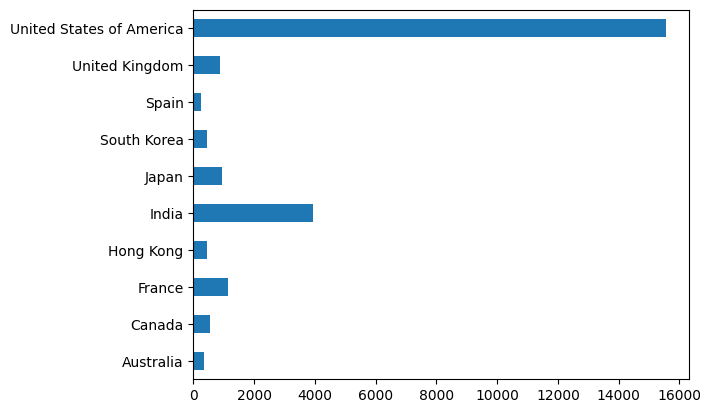

In [230]:
char_movies_countries.groupby('countries')['character_count'].sum().plot.barh(x='countries')

plt.ylabel(None)
plt.show()

As we can see, we have much more data on the american films, so we will normalize the data. After that let's look at the distribution of the global top 5 archetypes.

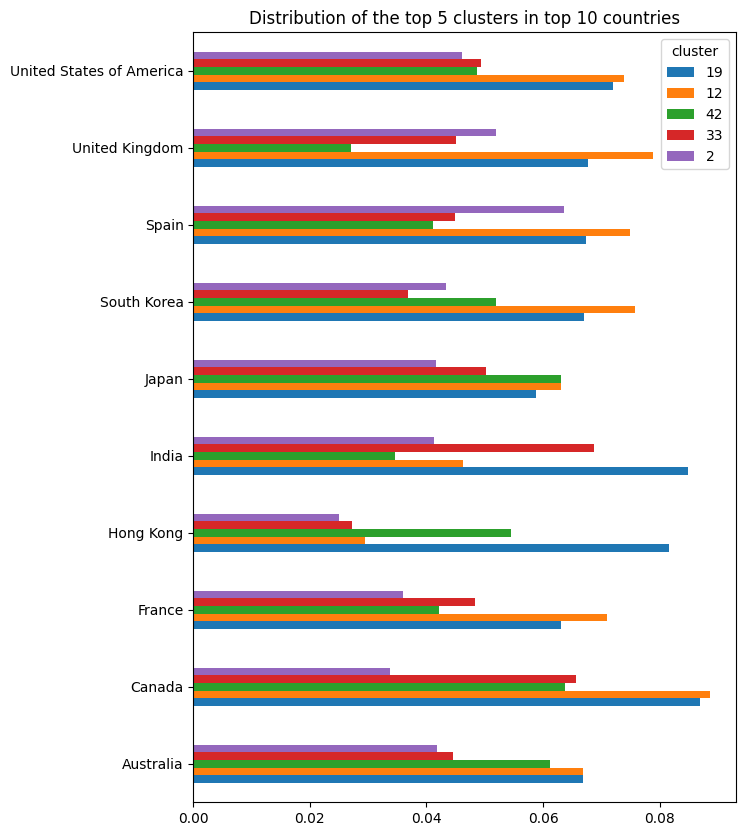

In [231]:
normalized_archetype_by_country = (archetype_by_country)/(archetype_by_country.values.sum(1).reshape(-1, 1))

normalized_archetype_by_country[top_clusters[:5]].plot.barh(figsize=(7, 10), title='Distribution of the top 5 clusters in top 10 countries')

plt.ylabel(None)
plt.show()

It's easy to notice the difference between this countries. We can notice the difference in the types of the most popular protagonists for example in India and Hong Kong compared to United Kingdom and Spain. In the first group, the most popular protagonists are those who act and achieve something, while in the second group the most popular protagonists are communicating more and travel.

Now, we can't say, that the distribution of the archetypes is different in different countries. But was it the case in 20th century?

/tmp/ipykernel_10365/3031707099.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



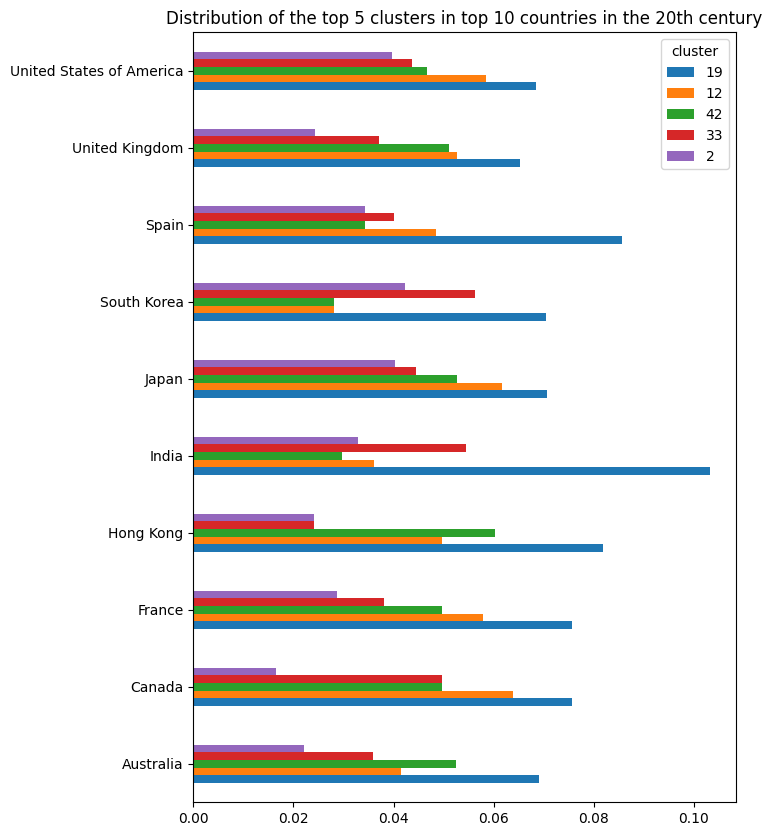

In [232]:
char_movies_countries = characters_and_movies[characters_and_movies['release_year'] < 2001]
char_movies_countries['countries'] = char_movies_countries['countries'].apply(lambda x: x[0] if x else 'Unknown')

char_movies_countries = char_movies_countries.groupby(['countries', 'cluster']).size().reset_index(name='character_count')

char_movies_countries = char_movies_countries[['countries', 'cluster', 'character_count']]

char_movies_countries = char_movies_countries[char_movies_countries['countries'].isin(top_countries)]
archetype_by_country = char_movies_countries.pivot(index='countries', columns='cluster', values='character_count').fillna(0)

normalized_archetype_by_country = (archetype_by_country)/(archetype_by_country.values.sum(1).reshape(-1, 1))

normalized_archetype_by_country[top_clusters[:5]].plot.barh(figsize=(7, 10), title='Distribution of the top 5 clusters in top 10 countries in the 20th century')

plt.ylabel(None)
plt.show()

We can notice the shift that hapend from the 20th to 21st century from more achieving to communicating protagonists.

# Movie success based on the archetypes

### Linear model for revenue prediction

To determine importance of the archetypes for the movie success, we can build the linear model and tell what are the most important archetypes based on the coefficient and p-value.

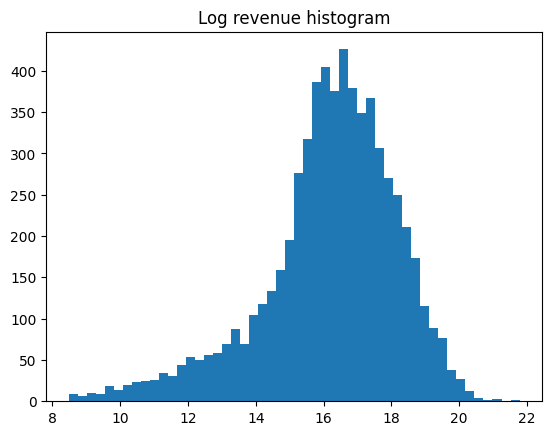

In [233]:
cluster_and_revenue = characters_and_movies[characters_and_movies['discounted_revenue'].notna()][['wiki_id', 'discounted_revenue']]
cluster_and_revenue['log_revenue'] = np.log(cluster_and_revenue['discounted_revenue'])
cluster_and_revenue = cluster_and_revenue[['wiki_id', 'log_revenue']].drop_duplicates().reset_index(drop=True)

revenues = cluster_and_revenue['log_revenue'].values
wiki_ids = cluster_and_revenue['wiki_id'].values

plt.hist(revenues, bins=50)
plt.title('Log revenue histogram')
plt.show()

In [234]:
import plotly.graph_objects as go

# Obtain the data
categories_movie_plot = ["Movies with Revenue", "Movies with Rating", "Movies with Rating and Revenue"]

movie_values = [movies['revenue'].notna().sum(),
          len(movies_with_rating),
          movies_with_rating['revenue'].notna().sum()]

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=categories_movie_plot, y=movie_values)])

# Update layout for better visualization
fig.update_layout(
    title="Statistics of Movies with Revenue and Rating",
    xaxis_title="Categories",
    yaxis_title="Number of Movies",
)

# Show the plot
fig.show()

In [235]:
clusters = np.zeros((len(cluster_and_revenue), 50)) #initializing the clusters
for i in range(len(wiki_ids)):
    wiki_id = wiki_ids[i]
    for c in characters_and_movies[characters_and_movies['wiki_id'] == wiki_id]['cluster'].values:
        clusters[i][c] = 1
        

cluster_revenue_data = pd.DataFrame(clusters, columns=[f'archetype_{i}' for i in np.arange(50)])
cluster_revenue_data['log_revenue'] = cluster_and_revenue['log_revenue']
cluster_revenue_data

,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,archetype_6,archetype_7,archetype_8,archetype_9,...,archetype_41,archetype_42,archetype_43,archetype_44,archetype_45,archetype_46,archetype_47,archetype_48,archetype_49,log_revenue
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.516023
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.995493
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.580253
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.047780
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.416037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.537968
6276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.758049
6277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15.875002
6278,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.663577


In [236]:
n = 50

model_str = "log_revenue ~ "
for i in range(n):
    model_str += "C(archetype_" + str(i) + ")+"

model_str_without_interaction = model_str.strip("+")

for i in range(n):
    for j in range(i+1, n):
        model_str += "C(archetype_" + str(i) + "):C(archetype_" + str(j) + ")+"

model_str = model_str.strip("+")

In [237]:
mod = smf.ols(formula = model_str_without_interaction, data = cluster_revenue_data)
res_without_interaction = mod.fit()
res_without_interaction.summary().tables[0]

Dep. Variable:,log_revenue,R-squared:,0.093
Model:,OLS,Adj. R-squared:,0.085
Method:,Least Squares,F-statistic:,12.71
Date:,"Fri, 22 Dec 2023",Prob (F-statistic):,7.97e-97
Time:,23:36:01,Log-Likelihood:,-12963.
No. Observations:,6280,AIC:,2.603e+04
Df Residuals:,6229,BIC:,2.637e+04
Df Model:,50,,
Covariance Type:,nonrobust,,


In [238]:
mod = smf.ols(formula = model_str, data = cluster_revenue_data)
res = mod.fit()
res.summary().tables[0]

Dep. Variable:,log_revenue,R-squared:,0.261
Model:,OLS,Adj. R-squared:,0.073
Method:,Least Squares,F-statistic:,1.388
Date:,"Fri, 22 Dec 2023",Prob (F-statistic):,1.23e-14
Time:,23:36:05,Log-Likelihood:,-12319.
No. Observations:,6280,AIC:,2.719e+04
Df Residuals:,5006,BIC:,3.578e+04
Df Model:,1273,,
Covariance Type:,nonrobust,,


Based on the significant improvement in R-squared metric, we can say that interactions between archetypes are important.

Next, let's look at p-values and coefficents to find out important archetypes and interactions.

In [239]:
significant_coefficients = res.params[res.pvalues <= 0.05].abs().sort_values(ascending=False)
sorted_coefficients = res.params.loc[significant_coefficients.index]

In [240]:
sorted_coefficients[:10]

Intercept                                        14.716896
C(archetype_22)[T.1.0]:C(archetype_44)[T.1.0]    -4.677605
C(archetype_24)[T.1.0]:C(archetype_37)[T.1.0]    -3.498758
C(archetype_7)[T.1.0]:C(archetype_25)[T.1.0]      3.207898
C(archetype_17)[T.1.0]:C(archetype_18)[T.1.0]    -3.132014
C(archetype_11)[T.1.0]:C(archetype_22)[T.1.0]     2.700693
C(archetype_3)[T.1.0]:C(archetype_8)[T.1.0]      -2.576108
C(archetype_34)[T.1.0]:C(archetype_36)[T.1.0]    -2.493908
C(archetype_25)[T.1.0]:C(archetype_35)[T.1.0]    -2.037947
C(archetype_11)[T.1.0]:C(archetype_17)[T.1.0]    -1.976874
dtype: float64

For example,the combination of archetype_22 and archetype_44 could be a bad combination and archetype_7 and archetype_25 could be a bad combination.



Next, let's look at anova results to determine the important archetypes and interactions.

In [241]:
sm.stats.anova_lm(res, robust='hc3').sort_values('PR(>F)')[:50]

,df,sum_sq,mean_sq,F,PR(>F)
C(archetype_42),1.0,312.408613,312.408613,84.120449,6.657694e-20
C(archetype_9),1.0,183.848871,183.848871,49.503915,2.246645e-12
C(archetype_19),1.0,130.507652,130.507652,35.141036,3.272133e-09
C(archetype_11),1.0,120.682120,120.682120,32.495372,1.263207e-08
C(archetype_45),1.0,109.163117,109.163117,29.393717,6.184129e-08
C(archetype_14),1.0,101.157582,101.157582,27.238113,1.871422e-07
C(archetype_3),1.0,93.392232,93.392232,25.147183,5.495113e-07
C(archetype_1),1.0,90.370611,90.370611,24.333568,8.363775e-07
C(archetype_38),1.0,72.016179,72.016179,19.391377,1.087062e-05
C(archetype_0),1.0,69.999476,69.999476,18.848351,1.443264e-05


# Actors success based on the archetypes

In [242]:
movies_rating_revenue = movies_with_rating[['wiki_id', 'discounted_revenue', 'averageRating']].dropna(subset=['discounted_revenue']).reset_index(drop=True)
movies_rating_revenue['discounted_revenue'] = np.log(movies_rating_revenue['discounted_revenue'])
movies_rating_revenue['norm_log_revenue'] = (movies_rating_revenue['discounted_revenue'] - np.min(movies_rating_revenue['discounted_revenue'])) * 10/ (np.max(movies_rating_revenue['discounted_revenue']) - np.min(movies_rating_revenue['discounted_revenue']))
movies_rating_revenue

,wiki_id,discounted_revenue,averageRating,norm_log_revenue
0,28703057,11.512925,5.3,2.281386
1,15130915,16.523561,6.0,6.046780
2,15340505,16.118096,5.8,5.742081
3,14613957,13.676570,3.1,3.907323
4,1762869,14.710373,5.7,4.684205
...,...,...,...,...
7334,142417,19.266960,8.0,8.108390
7335,16794053,16.769979,3.9,6.231958
7336,12005,15.192230,6.8,5.046311
7337,399433,19.240841,2.0,8.088763


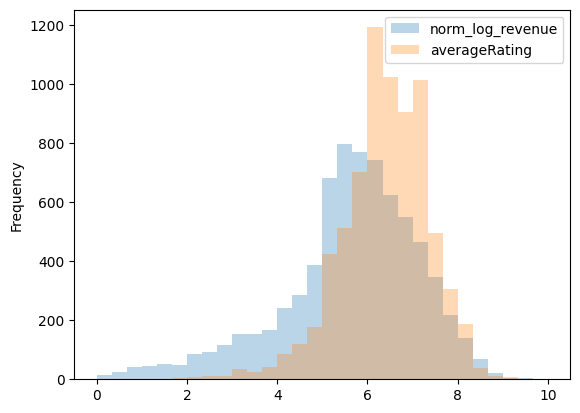

In [243]:
movies_rating_revenue[['norm_log_revenue', 'averageRating']].plot.hist(alpha=0.3, bins=30)
plt.show()

In [244]:
from scipy.stats import pearsonr

pearsonr(movies_rating_revenue['norm_log_revenue'].values, movies_rating_revenue['averageRating'].values)

PearsonRResult(statistic=0.20571324421003803, pvalue=5.822457999044762e-71)

We can see, that there is some statistically significant correlation, even though it's not wery big. We will use the sum of normalized log revenue and rating of the film as the metric for success.

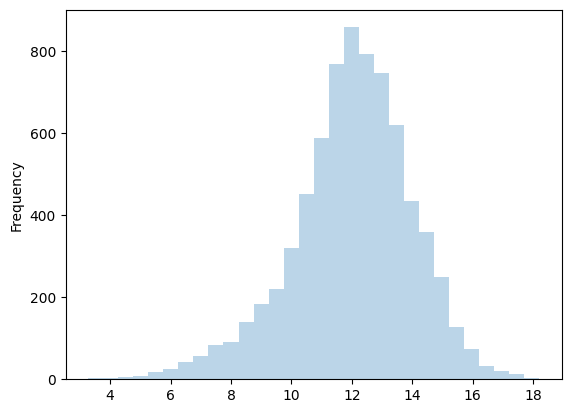

In [245]:
movies_rating_revenue['success'] = movies_rating_revenue['averageRating'] + movies_rating_revenue['norm_log_revenue']
movies_rating_revenue['success'].plot.hist(alpha=0.3, bins=30)
plt.show()

In [246]:
actors_and_characters['importance'] = actors_and_characters['adj'].apply(len) + actors_and_characters['active'].apply(len) + actors_and_characters['patient'].apply(len)
actors_and_characters['importance'] = actors_and_characters['importance'] / actors_and_characters.groupby('wiki_id')['importance'].transform('sum')
actors_and_characters

,character,actor,cluster,wiki_id,release_date,date_of_birth,sex,height,age,adj,active,patient,importance
2,Peeta Mellark,Josh Hutcherson,29,31186339,2012-03-12,1992-10-12,M,1.70,19.0,[son],"[take, reveal, mean, form, present, beg, tell]",[force],0.136364
31,Cato,Alexander Ludwig,15,31186339,2012-03-12,1992-05-07,M,1.88,19.0,[],[kill],"[encounter, wound, shoot]",0.075758
43,Katniss,Jennifer Lawrence,9,31186339,2012-03-12,1990-08-15,F,1.75,21.0,[],"[take, survive, drop, warn, run, shoot, presen...","[give, find, torment, spare, force, tell, warn]",0.287879
61,Katniss,Phillip Troy Linger,9,31186339,2012-03-12,1964-03-21,M,NaN,47.0,[],"[take, survive, drop, warn, run, shoot, presen...","[give, find, torment, spare, force, tell, warn]",0.287879
76,Rue,Amandla Stenberg,1,31186339,2012-03-12,1998-10-23,F,1.42,13.0,[die],"[draw, care, draw, trap]","[hear, stab, comfort, kill]",0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720803,Gwen,Carissa Capobianco,27,17208834,2008-10-13,1988-07-05,F,NaN,20.0,[],"[manage, hide]",[name],0.111111
720831,Kyle,Justin Welborn,30,17208834,2008-10-13,NaN,M,NaN,NaN,[enemy],"[run, carry, make, kill, bite]",[],0.194444
720835,Jensen,Lucas Till,16,17208834,2008-10-13,1990-08-10,M,1.78,18.0,[],"[smoke, open, catch]",[ask],0.138889
720843,Lindsey,Greyson Chadwick,33,17208834,2008-10-13,NaN,NaN,NaN,NaN,[],"[break, come, take, follow, look, force]","[take, call, kiss]",0.277778


In [247]:
actors_and_characters_with_success = actors_and_characters.merge(movies_rating_revenue[['wiki_id', 'success']], left_on='wiki_id', right_on='wiki_id')
actors_and_characters_with_success = actors_and_characters_with_success[['actor', 'cluster', 'date_of_birth', 'sex', 'height', 'age', 'importance', 'success']]
actors_and_characters_with_success.sample(10)

,actor,cluster,date_of_birth,sex,height,age,importance,success
11550,Reese Witherspoon,35,1976-03-22,F,1.560,28.0,0.285714,11.964544
1590,Aidan McArdle,27,1970,M,NaN,34.0,0.078125,12.321256
2072,Gary Oldman,10,1958-03-21,M,1.780,51.0,0.125000,14.585213
6731,Angelina Jolie,24,1975-06-04,F,1.730,24.0,0.309091,13.842753
982,Kristy McNichol,47,1962-09-11,F,1.600,15.0,0.142857,13.292397
1643,Gina Carano,12,1982-04-16,F,1.730,29.0,0.363636,11.786592
3141,Marcia Gay Harden,11,1959-08-14,F,1.638,47.0,0.111111,12.037814
9196,Demi Moore,42,1962-11-11,F,1.650,46.0,0.238095,11.302869
3108,Pierce Brosnan,31,1953-05-16,M,1.880,38.0,0.250000,11.764069
8028,Elisa Gabrielli,49,1966-12-15,F,NaN,41.0,0.038961,14.845493


In [248]:
actors_and_characters_with_success['weighted_success'] = actors_and_characters_with_success['importance'] * actors_and_characters_with_success['success']
top_actors = actors_and_characters_with_success.groupby('actor').agg({'weighted_success': ['sum', 'size'], 'cluster':list, 'sex':'last', 'date_of_birth':'last'}).sort_values(('weighted_success',  'sum'), ascending=False)

In [249]:
# Only look at the actors with at least 5 films
top_actors.columns = ['sum_success', 'num_films', 'clusters', 'sex', 'date_of_birth']
top_actors = top_actors.reset_index()
top_actors = top_actors[top_actors['num_films'] > 4]
top_actors

,actor,sum_success,num_films,clusters,sex,date_of_birth
0,Clint Eastwood,227.103688,26,"[24, 2, 24, 24, 31, 2, 42, 19, 48, 24, 19, 28,...",M,1930-05-31
1,Robert De Niro,222.028596,34,"[40, 15, 12, 33, 3, 47, 16, 24, 14, 19, 19, 12...",M,1943-08-17
2,Robin Williams,209.478433,34,"[9, 39, 1, 47, 42, 12, 19, 33, 12, 42, 24, 15,...",M,1951-07-21
3,Johnny Depp,206.656704,32,"[35, 16, 7, 39, 28, 19, 33, 12, 45, 45, 19, 29...",M,1963-06-09
4,Tom Hanks,191.831191,28,"[9, 19, 14, 40, 48, 42, 0, 2, 12, 14, 44, 44, ...",M,1956-07-09
...,...,...,...,...,...,...
1743,Richard Jenkins,6.981143,5,"[30, 35, 28, 28, 47]",M,1947-05-04
1750,William Fichtner,6.934461,5,"[35, 2, 47, 12, 11]",M,1956-11-27
1779,Xander Berkeley,6.791155,6,"[35, 12, 12, 10, 45, 33]",M,1955-12-16
1788,Jason Flemyng,6.745969,5,"[33, 1, 43, 42, 42]",M,1966-09-25


In [250]:
top_actors['year_of_birth'] = top_actors['date_of_birth'].apply(lambda x: int(x[:4]))

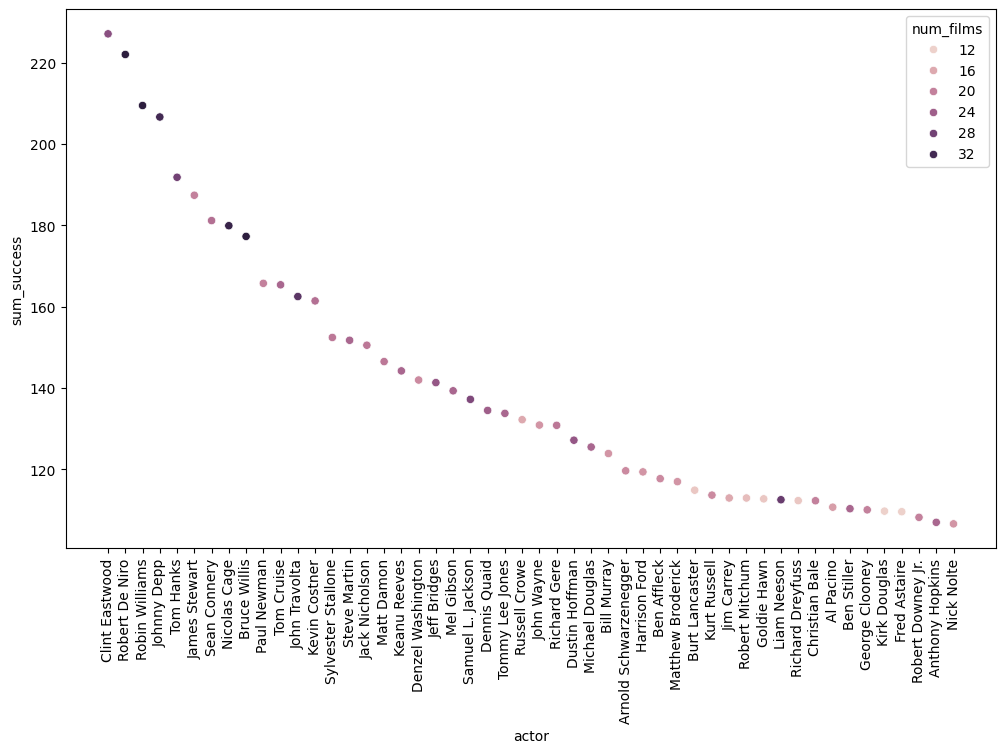

In [251]:
plt.figure(figsize=(12, 7))
sum_success_plot = sns.scatterplot(data=top_actors[:50], x='actor', y='sum_success', hue='num_films')
plt.xticks(rotation=90)
plt.show()

#### Archetype number and actor's success

In [252]:
top_actors['cluster_number'] = top_actors['clusters'].apply(lambda x: len(set(x)))
top_actors['clusters_to_films_ratio'] = top_actors['cluster_number']/top_actors['num_films']
top_actors

,actor,sum_success,num_films,clusters,sex,date_of_birth,year_of_birth,cluster_number,clusters_to_films_ratio
0,Clint Eastwood,227.103688,26,"[24, 2, 24, 24, 31, 2, 42, 19, 48, 24, 19, 28,...",M,1930-05-31,1930,14,0.538462
1,Robert De Niro,222.028596,34,"[40, 15, 12, 33, 3, 47, 16, 24, 14, 19, 19, 12...",M,1943-08-17,1943,17,0.500000
2,Robin Williams,209.478433,34,"[9, 39, 1, 47, 42, 12, 19, 33, 12, 42, 24, 15,...",M,1951-07-21,1951,20,0.588235
3,Johnny Depp,206.656704,32,"[35, 16, 7, 39, 28, 19, 33, 12, 45, 45, 19, 29...",M,1963-06-09,1963,16,0.500000
4,Tom Hanks,191.831191,28,"[9, 19, 14, 40, 48, 42, 0, 2, 12, 14, 44, 44, ...",M,1956-07-09,1956,19,0.678571
...,...,...,...,...,...,...,...,...,...
1743,Richard Jenkins,6.981143,5,"[30, 35, 28, 28, 47]",M,1947-05-04,1947,4,0.800000
1750,William Fichtner,6.934461,5,"[35, 2, 47, 12, 11]",M,1956-11-27,1956,5,1.000000
1779,Xander Berkeley,6.791155,6,"[35, 12, 12, 10, 45, 33]",M,1955-12-16,1955,5,0.833333
1788,Jason Flemyng,6.745969,5,"[33, 1, 43, 42, 42]",M,1966-09-25,1966,4,0.800000


Median of the cluster to film ratio:  0.8571428571428571


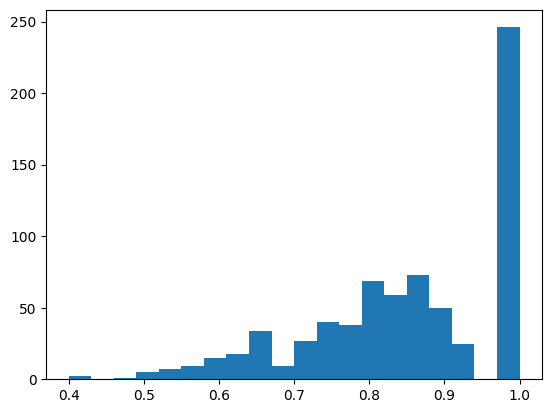

In [253]:
plt.hist(top_actors['clusters_to_films_ratio'], bins=20)
print('Median of the cluster to film ratio: ', np.median(top_actors['clusters_to_films_ratio']))

In [254]:
top_actors['many_archetypes'] = top_actors['clusters_to_films_ratio'].apply(lambda x: int(x > 0.70))

Now let's perform causal analysis.

In [255]:
norm_top_actors_data = top_actors[['sum_success', 'many_archetypes', 'year_of_birth', 'sex', 'num_films']].reset_index(drop=True)
norm_top_actors_data['sex'] =  norm_top_actors_data['sex'].apply(lambda x: int(x=='F'))
norm_top_actors_data['year_of_birth'] = norm_top_actors_data['year_of_birth'] - norm_top_actors_data['year_of_birth'].mean() / norm_top_actors_data['year_of_birth'].std()
norm_top_actors_data['num_films'] = norm_top_actors_data['num_films'] - norm_top_actors_data['num_films'].mean() / norm_top_actors_data['num_films'].std()


mod = smf.logit(formula='many_archetypes ~  year_of_birth + sex + num_films', data=norm_top_actors_data)
res = mod.fit()

# Extract the estimated propensity scores
norm_top_actors_data['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.340897
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        many_archetypes   No. Observations:                  727
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            3
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                  0.1933
Time:                        23:36:08   Log-Likelihood:                -247.83
converged:                       True   LL-Null:                       -307.22
Covariance Type:            nonrobust   LLR p-value:                 1.412e-25
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        51.8280     14.661      3.535      0.000      23.093      80.563
year_of_birth    -0.

In [256]:
import networkx as nx


def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

treatment_df = norm_top_actors_data[norm_top_actors_data['many_archetypes'] == 1]
control_df = norm_top_actors_data[norm_top_actors_data['many_archetypes'] == 0]

G = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching = nx.max_weight_matching(G)

In [257]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_norm_top_actors_data = norm_top_actors_data.iloc[matched]
balanced_norm_top_actors_data

,sum_success,many_archetypes,year_of_birth,sex,num_films,Propensity_score
231,49.295212,0,1827.770689,0,4.120047,0.958073
420,30.712687,1,1845.770689,0,9.120047,0.843154
9,165.746032,1,1817.770689,0,18.120047,0.659224
43,110.322730,1,1857.770689,0,21.120047,0.274167
132,67.919042,1,1860.770689,0,10.120047,0.749085
...,...,...,...,...,...,...
157,60.518004,0,1854.770689,0,8.120047,0.837689
68,92.528006,1,1839.770689,0,15.120047,0.661190
699,11.966772,1,1853.770689,0,3.120047,0.933563
125,70.105435,0,1866.770689,0,11.120047,0.677308


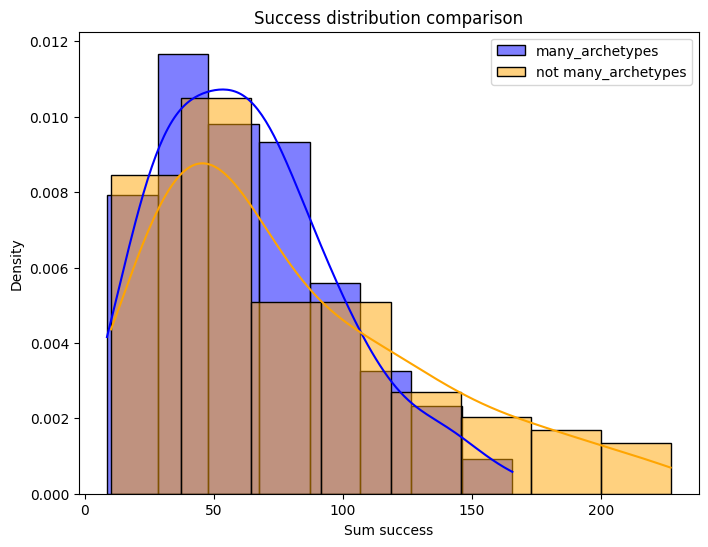

In [258]:
treated = balanced_norm_top_actors_data.loc[balanced_norm_top_actors_data['many_archetypes'] == 1]
control = balanced_norm_top_actors_data.loc[balanced_norm_top_actors_data['many_archetypes'] == 0]

plt.figure(figsize = (8, 6))
ax = sns.histplot(treated['sum_success'], kde=True, stat='density', color='blue', label='many_archetypes');
ax = sns.histplot(control['sum_success'], kde=True, stat='density', color='orange', label='not many_archetypes')
ax.set(title='Success distribution comparison',xlabel='sum success', ylabel='density')
plt.legend()
plt.xlabel("Sum success")
plt.ylabel("Density")
plt.show()

In [259]:
from scipy.stats import ttest_ind

ttest_ind(treated['sum_success'],control['sum_success'], alternative='less')

Ttest_indResult(statistic=-2.6628974960477607, pvalue=0.0041652126525349355)

Now we can say that actors, who have played less archetypes are statistically significantly more successful that those, who played more various archetypes.